In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import SR1, BFGS
from scipy.optimize import minimize

import os
import sys
sys.path.append('../core')
sys.path.append('../')
import confound_mdp
import confound_ope
import confound_env

from utils.utils import *

import copy

# Lower Bound Experiments

In [2]:
envs = []
# each row:
#   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]


horizon = 8
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, 
                                                                    slip = 0.04, confound_weight=0.6, small=True)
#R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])

'''
horizon = 8
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, confound_weight=0.6, small=False)
#R = -1*R
gridworldLarge = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworldLarge, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])
'''
'''
horizon = 10
pi_b, P, R, x_dist, u_dist, gamma = confound_env.randwalk(pu1 = 1/6, pu2 = 1/2.5, pis1u1 = 1.0/4, pis2u1 = 1.0/6)
R = -1*R
randwalk = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([randwalk, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])
'''

'\nhorizon = 10\npi_b, P, R, x_dist, u_dist, gamma = confound_env.randwalk(pu1 = 1/6, pu2 = 1/2.5, pis1u1 = 1.0/4, pis2u1 = 1.0/6)\nR = -1*R\nrandwalk = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)\n\nnStates = P.shape[2]\nnActions = P.shape[1]\n\npi_e = np.zeros((nStates, nActions))\nfor i in range(nStates):\n    pi_e[i] = [0.3, 0.7]\n    \nenvs.append([randwalk, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])\n'

In [145]:
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from itertools import repeat

def collect_sample(nsamples, mdp, pi_b, horizon, seed, iid=True):
    np.random.seed(seed)
    dataset = []
    for _ in range(nsamples):
        traj = mdp.generate_trajectory(pi_b, horizon, iid)
        dataset.append(traj)
    dataset = np.array(dataset)
    # x, a, u, x', r
    return dataset

def getSamplesMultiProc(samples, mdp, pi_b, horizon, start_seed=0, iid=True, nprocs=None):
    if nprocs is None:
        nprocs = multiprocessing.cpu_count()
    with ProcessPoolExecutor(max_workers=nprocs, mp_context=multiprocessing.get_context('fork')) as executor:
        future = executor.map(collect_sample, [int(samples/nprocs) for i in range(nprocs)], repeat(copy.deepcopy(mdp)), 
                              repeat(copy.deepcopy(pi_b)), repeat(horizon), [i+start_seed for i in range(nprocs)], repeat(iid))
    dataset = np.vstack(list(future))
    return dataset


fqe_envs = []
mb_envs = []

gams = [1, 1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [1, 1.1, 1.5, 2, 3, 4, 6, 8, 10]
nPbs = len(Pbs)

#hadds = [0, 5, 10]
hadds = [0]

for mdp, pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma in envs:
    
    print("---")
    
    for h in hadds:
        horizon = base_horizon + h
        
        print("running env with horizon " + str(horizon))

        dataset = getSamplesMultiProc(int(10000), mdp, pi_b, horizon)
        data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
        Phat = confound_ope.estimate_P(dataset, mdp)
        pihat = confound_ope.estimate_pi(dataset, mdp)
        for a in range(nActions):
            for s in range(nStates):
                if Phat[a,s].sum() == 0:
                    Phat[a,s,term] = 1
                if pihat[s].sum() == 0:
                    pihat[s,:] = 1/nActions
        pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]
        
        # This is the actual reward_sa
        # P(s,a,s') * R(s,a,s')
        # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
        R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
        P_spsa = Phat.transpose((2, 1, 0))
        n = data.shape[0]
        Rhat_sa = (Phat * confound_ope.estimate_R(dataset, mdp)).sum(axis=2).T

         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())

        '''
        # no confounding:
        print("value of pi_e with no confounding")
        Q0 = np.zeros((nStates, nActions))
        nom_q = Q0.copy()
        for t in range(horizon):
            nom_q = fitted_q_update(nom_q, pi_e, dataset, Rhat_sa, mdp)
        print(mdp.get_value(nom_q,pi_e)[1])

        fqe_results = []

        print("now running C-FQE")
        for i,gam in enumerate(gams):
            Q0 = np.zeros((nStates, nActions))
            q_reparam_samp = Q0.copy()
            for t in range(horizon):
                q_reparam_samp = fitted_q_update_reparam_sampling(q_reparam_samp, pi_e, pihat, Pb_spsa, gam, R_sa, data, mdp)
            fqe_results.append(mdp.get_value(q_reparam_samp,pi_e)[0])
            
        '''

        '''
        print("now running robust mdps...")
        mb_results = np.zeros((nGams, nPbs))

        for i,gam in tqdm(enumerate(gams)):
            for j,P_bound in enumerate(Pbs):
                V0 = np.zeros(nStates)
                fixed_u_v = V0.copy()
                for t in range(horizon):
                    fixed_u_v = confound_ope.fixed_u_gp_s_rect(fixed_u_v, pi_e, 0.50, Phat, pihat, P_bound, gam, mdp)
                mb_results[i,j] = fixed_u_v @ mdp.x_dist

        fqe_envs.append(fqe_results)
        mb_envs.append(mb_results)
        '''

---
running env with horizon 8
value of pi_b
-0.5017940573937666


In [14]:
from numba import njit
#Ptrue_spsa = np.einsum('u,uasp->psa', u_dist, P)
pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)
@njit
def getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P):
    prob = np.zeros((nStates, nStates, nActions))
    for sp in range(nStates):
        for s in range(nStates):
            for a in range(nActions):
                for u in range(len(u_dist)):
                    prob[sp, s, a] += u_dist[u] * pi_b[u, s, a] * (1/pi_bsa[s,a]) * P[u, a, s, sp]
    return prob
Pb_spsa = getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P)



In [15]:
def CFQE(f, pi_e, pi_bsa, Pb_spsa, gam, R_sa):
    nStates = Pb_spsa.shape[0]
    nActions = Pb_spsa.shape[2]
    f_hat = np.zeros((nStates, nActions))
    for s in range(nStates):
        for a in range(nActions):
            #c = pi_bsa[s,a]*np.array([R_sa[s,a] + np.dot(pi_e[sp,:], f[sp,:]) for sp in range(nStates)])
            c = np.array([Pb_spsa[sp,s,a]*(R_sa[s,a] + np.dot(pi_e[sp,:], f[sp,:])) for sp in range(nStates)])
            lower = (pi_bsa[s,a] + (1/gam)*(1-pi_bsa[s,a])),
            upper = (gam + pi_bsa[s,a]*(1-gam)),
            bounds = [lower, upper]
            f_hat[s,a] = scipy.optimize.linprog(c, A_eq = [Pb_spsa[:,s,a]],
                                                 b_eq = [1], bounds=bounds).fun
    return f_hat

# Here's where our work starts

For the Gridworld problem, we have a 4x4 gridworld. 
`nStates` is 16, and `nActions` is 4. Of the things we're interested in, 
$$\mathbb{P} \in \mathbb{R}^{U \times A \times  S \times S'}, R \in \mathbb{R}^{A \times S \times S'}, \pi_b \in \mathbb{R}^{U \times S \times  A}, \pi_e \in \mathbb{R}^{S \times A}$$

`P` sums to 128. That, divided by `nStates` and then `nActions`, yields 2. I think then, that `P` gives the conditional transition probabilities given the selection of hidden state $U$.

`Phat` and `pihat` are estimates of the transition probabilities and behavior policy respectively with $U$ marginalized out. `Phat` sums to 64, and is given by the same calculation method of $N(s, a, s')/N(s, a)$ as $\hat{\mathbb{P}}_{\pi_b}(s' | s, a)$, so we can conclude that it is that. Permuting axes to be ordered (s', s, a) gives us `P_spsa`. Additionally, `pihat[a, s]` really gives $\hat{\pi_b}(a | s)$. 

Define `R_sa` to be the array of rewards for each state-action pair. Bruns-Smith (2021) sets `R[:, i, :]` to be a flattened copy of the grid. That's not really what we're interested in, but we can average the transition probabilities among the distribution of u, take the element-wise product with the `R` array, sum it over the $S'$ axis and take the transpose to obtain `R_sa`.

Actions are indexed WENS

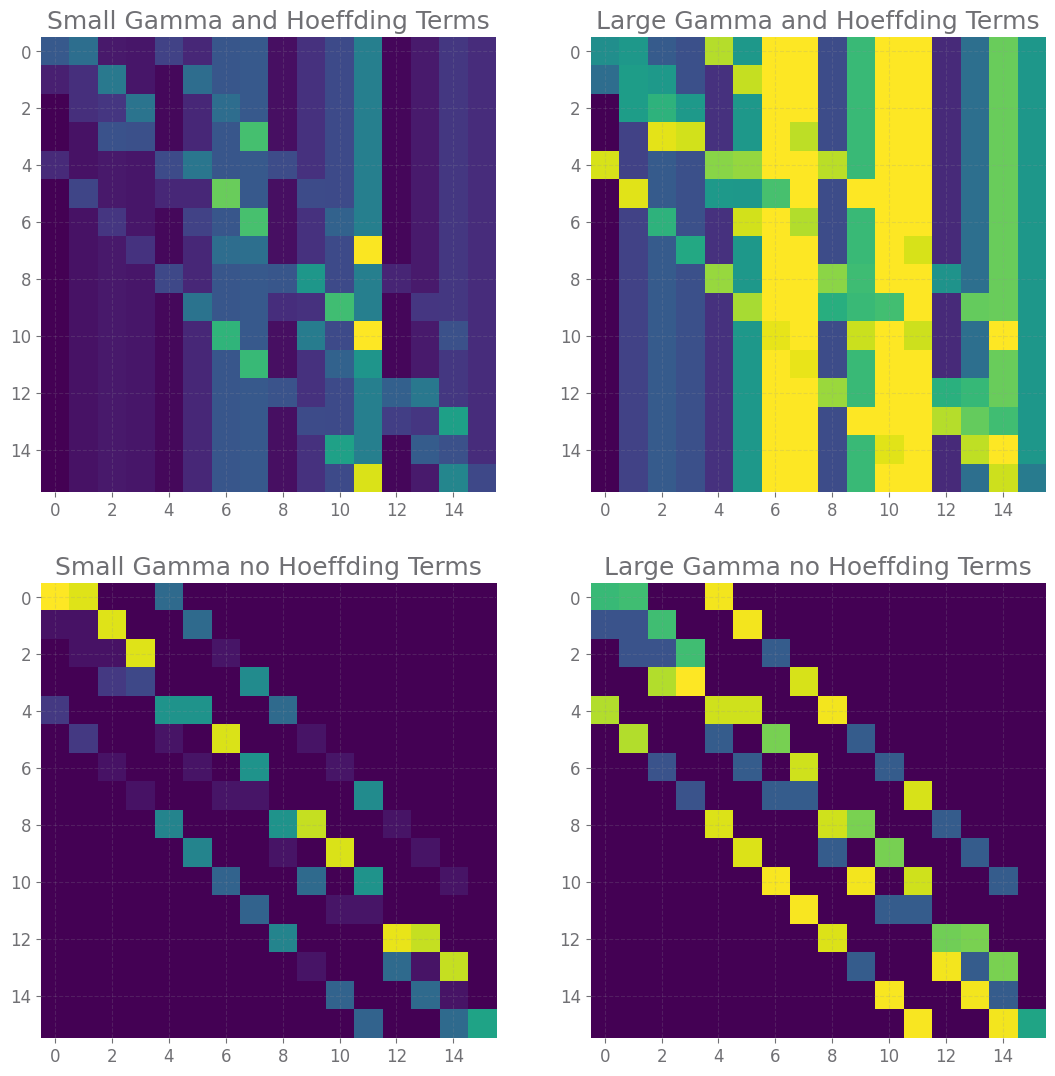

In [16]:
N_sa = np.zeros((nStates, nActions))
for s,a,u,sp,r in data:
    N_sa[int(s),int(a)] += 1

def getBounds(gam, delta, pi_bsa, Pb_spsa, N_sa, hoeffding=False):
    nStates = N_sa.shape[0]
    nActions = N_sa.shape[1]
    alpha_sa = pi_bsa + (1/gam) * (1-pi_bsa)
    beta_sa = gam + pi_bsa*(1-gam)
    if hoeffding:
        nStates = N_sa.shape[0]
        nActions = N_sa.shape[1]
        n = np.sum(N_sa)
        G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa - np.sqrt(np.reciprocal(2*N_sa.astype(float)) * np.log((2*n*(nStates**2)*nActions)/delta)))
        G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa + np.sqrt(np.reciprocal(2*N_sa.astype(float)) * np.log((2*n*(nStates**2)*nActions)/delta)))
        return np.maximum(0, G_lb), np.minimum(1, G_ub)
    else:
        return np.maximum(0, alpha_sa[np.newaxis,:,:]*Pb_spsa), np.minimum(1, beta_sa[np.newaxis,:,:]*Pb_spsa)

G_lb, G_ub = getBounds(gams[-1], 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=True)
vmin=np.min(G_ub-G_lb)
vmax=np.max(G_ub-G_lb)
action = 0
fig, axs = plt.subplots(2, 2, figsize=(13,13))
G_lb, G_ub = getBounds(gams[0], 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=True)
axs[0, 0].imshow((G_ub - G_lb)[:,:,action], vmin=vmin, vmax=vmax)
axs[0, 0].imshow((G_ub - G_lb)[:,:,action])
axs[0, 0].set_title('Small Gamma and Hoeffding Terms')
G_lb, G_ub = getBounds(gams[-1], 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=True)
axs[0, 1].imshow((G_ub - G_lb)[:,:,action], vmin=vmin, vmax=vmax)
axs[0, 1].imshow((G_ub - G_lb)[:,:,action])
axs[0, 1].set_title('Large Gamma and Hoeffding Terms')
G_lb, G_ub = getBounds(gams[0], 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=False)
smallGam = (G_ub - G_lb)[:,:,action]
axs[1, 0].imshow((G_ub - G_lb)[:,:,action], vmin=vmin, vmax=vmax)
axs[1, 0].imshow((G_ub - G_lb)[:,:,action])
axs[1, 0].set_title('Small Gamma no Hoeffding Terms')
G_lb, G_ub = getBounds(gams[-1], 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=False)
largeGam = (G_ub - G_lb)[:,:,action]
axs[1, 1].imshow((G_ub - G_lb)[:,:,action], vmin=vmin, vmax=vmax)
axs[1, 1].imshow((G_ub - G_lb)[:,:,action])
axs[1, 1].set_title('Large Gamma no Hoeffding Terms')

plt.savefig('HoeffdingCompare.png')

G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa - np.sqrt(np.reciprocal(2*N_sa.astype(float)) * np.log((2*n*(nStates**2)*nActions)/delta)))
G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa + np.sqrt(np.reciprocal(2*N_sa.astype(float)) * np.log((2*n*(nStates**2)*nActions)/delta)))
plt.imshow((G_ub - G_lb)[:,:,0])

In [17]:
import gurobipy as gp
from gurobipy import GRB
import time


def softtime(model, where):
    softlimit = 5
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()
            
def cb(model, where):
    if where == GRB.Callback.MIPNODE:
        # Get model objective
        obj = model.cbGet(GRB.Callback.MIPNODE_OBJBST)

        # Has objective changed?
        if abs(obj - model._cur_obj) > 1e-4:
            # If so, update incumbent and time
            model._cur_obj = obj
            model._time = time.time()

    # Terminate if objective has not improved in 20s
    if time.time() - model._time > 10:
        model.terminate()

def mbrlLoop(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, so=0, lb=None, ub=None):
    objVals = []
    if lb is None:
        lb = -10*np.ones(len(gams))
    if ub is None:
        ub = np.ones(len(gams))
    
    for idx, gam in enumerate(gams):
        #alpha_sa = pi_bsa + (1/gam) * (1-pi_bsa)
        #beta_sa = gam + pi_bsa*(1-gam)
        #G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa - 
        #                                 np.sqrt(np.reciprocal(2*N_sa.astype(float)) * 
        #                                np.log((2*n*(nStates**2)*nActions)/delta)))
        #G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa + 
        #                                np.sqrt(np.reciprocal(2*N_sa.astype(float)) * 
        #                                np.log((2*n*(nStates**2)*nActions)/delta)))
        #G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa)
        #G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa)
        G_lb, G_ub = getBounds(gam, 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=False)
        G_lb = np.maximum(0, G_lb)
        G_ub = np.minimum(1, G_ub)
        m = gp.Model('bilinear')
        m.setParam('NonConvex', 2)
        m.setParam("OutputFlag", 0)
        m.setParam('Presolve', 1)
        #m.setParam('Aggregate', 0)
        #m.setParam('NumericFocus', 3)
        #m.setParam('BarHomogeneous', 1)
        #m.setParam('BarCorrectors', 1000)
        #m.setParam('OptimalityTol', 1e-7)
        #m.setParam('FeasibilityTol', 1e-7)
        #m.setParam('BarConvTol', 1e-7)
        #m.setParam('BarQCPConvTol', 1e-7)
        #m.setParam('MIPFocus', 1)
        #m.setParam("OutputFlag", 0)
        #m.setParam('Method', 2)

        # V_2, ... , V_H <=> [0, ..., H-1), H-1 x S sized
        V = m.addVars(horizon, nStates, lb=lb[idx], ub=ub[idx], vtype=GRB.CONTINUOUS) 
        Prob_spsa = m.addVars(nStates, nStates, nActions, lb=0, ub=1, vtype=GRB.CONTINUOUS)

        m.update()
        
        # Prob matrix membership constraint
        for sp in range(nStates):
            for s in range(nStates):
                for a in range(nActions):
                    m.addConstr(Prob_spsa[sp, s, a] >= float(G_lb[sp, s, a]))
                    m.addConstr(Prob_spsa[sp, s, a] <= float(G_ub[sp, s, a]))

        # Prob matrix row sum constraint
        for s in range(nStates):
            for a in range(nActions):
                m.addConstr(gp.quicksum(Prob_spsa[sp, s, a] 
                                         for sp in range(nStates)) == 1)

        for s in range(nStates):
            m.addConstr(V[horizon-1, s] == 0)
            
        #for h in range(horizon):
        #    m.addConstr(V[h, 15] == 0)

        # Bellman Backup constraints: H-1 x S ordinary constraints for h = 2,...,H
        for h in range(horizon-1):
            for s in range(nStates):
                m.addConstr(V[h, s] == (gp.quicksum(pi_e[s, a]*R_sa[s, a]
                                                    for a in range(nActions)) + 
                                       gp.quicksum(pi_e[s, a]*Prob_spsa[sp,s,a]*V[h+1,sp] 
                                                    for a in range(nActions) 
                                                    for sp in range(nStates))))
        
        # Directly maximize the quadratic form for V_1(s0). 
        # Substitute so for what we previously called s. 
        # We need V_2(\cdot) in the RHS, so as before subtract 2 and take V[0, sp]
        obj = (gp.quicksum(pi_e[so, a]*R_sa[so, a] 
                            for a in range(nActions)) + 
                gp.quicksum(pi_e[so, a]*Prob_spsa[sp,so,a]*V[0,sp] 
                            for a in range(nActions) 
                            for sp in range(nStates)))
        
        
        m.setObjective(obj, GRB.MINIMIZE)
        m._cur_obj = float('inf')
        m._time = time.time()

        m.optimize(cb)
        #m.optimize()
        try:
            objVals.append(m.objVal)
        except:
            objVals.append(float('inf'))
    return objVals

In [18]:
# min \forall h \forall s
def mbrlRelax(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, prob=False):
    nStates = N_sa.shape[0]
    nActions = N_sa.shape[1]
    Vgams = []
    #for gam in [gams[-1]]:
    for gam in gams:
        V = np.zeros((horizon+1, nStates))
        for h in reversed(range(horizon)):
            #alpha_sa = pi_bsa + (1/gam) * (1-pi_bsa)
            #beta_sa = gam + pi_bsa*(1-gam)
            #delta = 0.05
            #G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa - 
            #                                 np.sqrt(np.reciprocal(2*N_sa.astype(float)) * 
            #                                np.log((2*n*(nStates**2)*nActions)/delta)))
            #G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa + 
            #                                np.sqrt(np.reciprocal(2*N_sa.astype(float)) * 
            #                                np.log((2*n*(nStates**2)*nActions)/delta)))
            #G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa)
            #G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa)
            G_lb, G_ub = getBounds(gam, 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=False)
            G_lb = np.maximum(0, G_lb)
            G_ub = np.minimum(1, G_ub)
            for so in range(nStates):
            #for so in range(1):
                m = gp.Model()
                m.setParam("OutputFlag", 0)
                #m.setParam('Presolve', 0)

                Prob_spsa = m.addVars(nStates, nStates, nActions, lb=0, ub=1, vtype=GRB.CONTINUOUS)

                # Prob matrix membership constraint
                for sp in range(nStates):
                    for s in range(nStates):
                        for a in range(nActions):
                            m.addConstr(Prob_spsa[sp, s, a] >= float(G_lb[sp, s, a]))
                            m.addConstr(Prob_spsa[sp, s, a] <= float(G_ub[sp, s, a]))

                # Prob matrix row sum constraint
                for s in range(nStates):
                    for a in range(nActions):
                        m.addConstr(gp.quicksum(Prob_spsa[sp, s, a] 
                                                 for sp in range(nStates)) == 1)

                # Substitute so for what we previously called s. 
                obj = (gp.quicksum(pi_e[so, a]*R_sa[so, a] 
                                    for a in range(nActions)) + 
                        gp.quicksum(pi_e[so, a]*Prob_spsa[sp,so,a]*V[h+1, sp]
                                    for a in range(nActions) 
                                    for sp in range(nStates)))

                m.setObjective(obj, GRB.MINIMIZE)

                m.optimize()

                V[h, so] = m.objVal
        Vgams.append(V[0,:])
        #for h in reversed(range(horizon)):
        #    print(V[h,:])
    #return np.array(Vgams)
    if prob:
        Prob_ret = np.zeros((nStates, nStates, nActions))
        for sp in range(nStates):
            for s in range(nStates):
                for a in range(nActions):
                    Prob_ret[sp,s,a] = Prob_spsa[sp,s,a].x
        return Prob_ret
    else:
        return np.array(Vgams)

Prob_ret = mbrlRelax(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, prob=True)
recursiveV(0,0,pi_e,R_sa,Pb_spsa)

In [19]:
V = np.zeros((horizon+1, nStates))
def recursiveV(h, s, pi_e, R_sa, Pb_spsa):
    if h == horizon:
        return 0
    elif V[h,s] != 0:
        return V[h,s]
    else:
        Vhp = np.array([recursiveV(h+1,sp, pi_e, R_sa, Pb_spsa) for sp in range(nStates)])
        V[h+1,:] = Vhp
        return pi_e[s,:].T @ (R_sa[s,:] + Pb_spsa[:,s,:].T @ Vhp)
V = np.zeros((horizon+1, nStates))
recursiveV(0, 0, pi_e, R_sa, Pb_spsa)

-0.2095261782838665

## Neural Nets for Computing Value Lower Bound

In [20]:

import torch
from torch.cuda.amp import custom_bwd, custom_fwd
from torch import nn
#device = torch.device('mps')
device = torch.device('cuda')



class DifferentiableClamp(torch.autograd.Function):
    """
    In the forward pass this operation behaves like torch.clamp.
    But in the backward pass its gradient is 1 everywhere, as if instead of clamp one had used the identity function.
    """

    @staticmethod
    @custom_fwd
    def forward(ctx, input, min, max):
        return input.clamp(min=min, max=max)
        #return torch.max(torch.min(input, max), min)

    @staticmethod
    @custom_bwd
    def backward(ctx, grad_output):
        return grad_output.clone(), None, None


def dclamp(input, min, max):
    """
    Like torch.clamp, but with a constant 1-gradient.
    :param input: The input that is to be clamped.
    :param min: The minimum value of the output.
    :param max: The maximum value of the output.
    """
    return DifferentiableClamp.apply(input, min, max)

In [21]:
class ValueEstimatorNaive(nn.Module):
    def __init__(self, nStates, nActions, horizon, pi_e, R_sa, Pb_spsa, lb, ub, so=0, device=device):
        super(ValueEstimatorNaive, self).__init__()
        Pcopy = copy.deepcopy(Pb_spsa)
        self.nStates = nStates
        self.nActions = nActions
        self.horizon = horizon
        self.so = so
        self.pi_e = torch.from_numpy(copy.deepcopy(pi_e)).to(device)
        self.R_sa = torch.from_numpy(copy.deepcopy(R_sa)).to(device)
        self.lb = torch.from_numpy(copy.deepcopy(lb)).to(device)
        self.ub = torch.from_numpy(copy.deepcopy(ub)).to(device)
        
        self.pi_e,self.R_sa=self.pi_e.type(torch.DoubleTensor),self.R_sa.type(torch.DoubleTensor)
        self.lb,self.ub=self.lb.type(torch.DoubleTensor),self.ub.type(torch.DoubleTensor)
        self.P = nn.ParameterList([nn.Parameter(torch.from_numpy(copy.deepcopy(Pcopy[:,s,:])).to(device), 
                                                requires_grad=True) for s in range(nStates)])

    def forward(self):
        # ParameterList can act as an iterable, or be indexed using ints
        Vhp = [torch.zeros(self.nStates).type(torch.DoubleTensor) for h in range(self.horizon)]
        # Bellman Backup constraints: H-1 x S ordinary constraints for h = 2,...,H
        for h in range(self.horizon-1):
            Vhp[h+1] = torch.stack([self.pi_e[s,:].T @ (self.R_sa[s,:] + self.P[s].T @ Vhp[h]) 
                               for s in range(nStates)])
            for s in range(self.nStates):
                self.P[s].data = self.P[s].data / torch.sum(self.P[s].data, dim=0)
                self.P[s].data = dclamp(self.P[s].data, self.lb[:,s,:], self.ub[:,s,:])
        return self.pi_e[self.so,:].T @ (self.R_sa[self.so,:] + self.P[self.so].T @ Vhp[-1])
    
    

In [22]:
from cvxpylayers.torch import CvxpyLayer
import cvxpy as cp
class ValueEstimator(nn.Module):
    def __init__(self, nStates, nActions, horizon, pi_e, R_sa, Pb_spsa, lb, ub, so=0, device=device):
        super(ValueEstimator, self).__init__()
        Pcopy = copy.deepcopy(Pb_spsa)
        self.nStates = nStates
        self.nActions = nActions
        self.horizon = horizon
        self.so = so
        self.pi_e = torch.from_numpy(copy.deepcopy(pi_e)).type(torch.float32).to(device)
        self.R_sa = torch.from_numpy(copy.deepcopy(R_sa)).type(torch.float32).to(device)
        self.lb = torch.from_numpy(copy.deepcopy(lb)).type(torch.float32).to(device)
        self.ub = torch.from_numpy(copy.deepcopy(ub)).type(torch.float32).to(device)
        
        self.pi_e,self.R_sa=self.pi_e.type(torch.float32),self.R_sa.type(torch.float32)
        self.lb,self.ub=self.lb.type(torch.float32),self.ub.type(torch.float32)
        self.P = nn.ParameterList([nn.Parameter(torch.from_numpy(copy.deepcopy(Pcopy[:,s,:])).type(torch.float32).to(device), 
                                                requires_grad=True) for s in range(nStates)])
        self.PsLayers = []
        for s in range(self.nStates):
            projPs = cp.Variable(shape=self.P[s].shape)
            Ps = cp.Parameter(shape=self.P[s].shape)
            lbs = cp.Parameter(shape=self.lb[:,s,:].shape)
            ubs = cp.Parameter(shape=self.ub[:,s,:].shape)
            obj = cp.sum(cp.square(Ps - projPs))
            constraints = [projPs.T @ np.ones(nStates) == np.ones(nActions)]
            constraints += [lbs <= projPs]
            constraints += [projPs <= ubs]
            problem = cp.Problem(cp.Minimize(obj), constraints)
            layer = CvxpyLayer(problem, parameters=[Ps, lbs, ubs], variables=[projPs])
            self.PsLayers.append(layer)
            
                
    def project(self):
        for s in range(self.nStates):
            self.P[s].data = self.PsLayers[s](self.P[s].data, self.lb[:,s,:], self.ub[:,s,:])[0]
            
    def forward(self):
        # ParameterList can act as an iterable, or be indexed using ints
        #Vhp = torch.zeros(self.nStates).type(torch.DoubleTensor)
        Vhp = [torch.zeros(self.nStates).type(torch.float32).to(device) for h in range(self.horizon)]
        # Bellman Backup constraints: H-1 x S ordinary constraints for h = 2,...,H
        
        for h in range(self.horizon-1):
            Vhp[h+1] = torch.stack([self.pi_e[s,:].T @ (self.R_sa[s,:] + self.P[s].T @ Vhp[h]) 
                               for s in range(nStates)])
        return self.pi_e[self.so,:].T @ (self.R_sa[self.so,:] + self.P[self.so].T @ Vhp[-1])
    
        '''
        for h in range(self.horizon-1):
            Vhp = torch.stack([self.pi_e[s,:].T @ (self.R_sa[s,:] + self.P[s].T @ Vhp) 
                               for s in range(nStates)])
            #proj
            #for s in range(self.nStates):
            #    self.P[s].data = self.PsLayers[s](self.P[s].data, self.lb[:,s,:], self.ub[:,s,:])[0]
        return self.pi_e[self.so,:].T @ (self.R_sa[self.so,:] + self.P[self.so].T @ Vhp)
        '''
    
    

In [23]:
from cvxpylayers.torch import CvxpyLayer
import cvxpy as cp
class PolicyImprover(nn.Module):
    def __init__(self, nStates, nActions, horizon, pi_e, R_sa, Pb_spsa, lb, ub, x_dist):
        super(PolicyImprover, self).__init__()
        Pcopy = copy.deepcopy(Pb_spsa)
        self.nStates = nStates
        self.nActions = nActions
        self.horizon = horizon
        self.R_sa = torch.from_numpy(copy.deepcopy(R_sa))
        self.lb = torch.from_numpy(copy.deepcopy(lb))
        self.ub = torch.from_numpy(copy.deepcopy(ub))
        
        self.x_dist = torch.tensor(x_dist, requires_grad=False)
        
        self.R_sa = self.R_sa.type(torch.DoubleTensor)
        self.lb,self.ub=self.lb.type(torch.DoubleTensor),self.ub.type(torch.DoubleTensor)
        self.P = nn.ParameterList([nn.Parameter(torch.from_numpy(copy.deepcopy(Pcopy[:,s,:])), 
                                                requires_grad=True) for s in range(nStates)])
        self.pi_e = nn.ParameterList([nn.Parameter(torch.nn.init.uniform_(torch.from_numpy(copy.deepcopy(pi_e[s])), -1, 1), 
                                                   requires_grad=True)
                                      for s in range(nStates)])
        
        self.PsLayers = []
        for s in range(self.nStates):
            projPs = cp.Variable(shape=self.P[s].shape)
            Ps = cp.Parameter(shape=self.P[s].shape)
            lbs = cp.Parameter(shape=self.lb[:,s,:].shape)
            ubs = cp.Parameter(shape=self.ub[:,s,:].shape)
            obj = cp.sum(cp.square(Ps - projPs))
            constraints = [projPs.T @ np.ones(nStates) == np.ones(nActions)]
            constraints += [lbs <= projPs]
            constraints += [projPs <= ubs]
            problem = cp.Problem(cp.Minimize(obj), constraints)
            layer = CvxpyLayer(problem, parameters=[Ps, lbs, ubs], variables=[projPs])
            self.PsLayers.append(layer)
            
    def project(self):
        for s in range(self.nStates):
            self.P[s].data = self.PsLayers[s](self.P[s].data, self.lb[:,s,:], self.ub[:,s,:])[0]
            
    def forward(self):
        # ParameterList can act as an iterable, or be indexed using ints
        #Vhp = torch.zeros(self.nStates).type(torch.DoubleTensor)
        Vhp = [torch.zeros(self.nStates).type(torch.DoubleTensor) for h in range(self.horizon+1)]
        # Bellman Backup constraints: H-1 x S ordinary constraints for h = 2,...,H
        
        for h in range(self.horizon):
            Vhp[h+1] = torch.stack([torch.softmax(self.pi_e[s], -1).T @ (self.R_sa[s,:] + self.P[s].clone().T @ Vhp[h]) 
                               for s in range(nStates)])
        return torch.matmul(Vhp[-1], self.x_dist) 
        #should have no need to change to long term average dist over pi_theta, as episodic RL, so use start value/dist
        #source: https://www.davidsilver.uk/wp-content/uploads/2020/03/pg.pdf
        
    
    

In [24]:
def getTorchVals(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, so=0, hoeffding=False):
    nStates = N_sa.shape[0]
    nActions = N_sa.shape[1]
    torchLoss = []
    for gam in gams:
        G_lb, G_ub = getBounds(gam, 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=hoeffding)
        valEst = ValueEstimator(nStates, nActions, horizon, pi_e, R_sa, Pb_spsa, G_lb, G_ub, so)
        
        optimizer = torch.optim.SGD(valEst.parameters(), lr=5e-1, momentum=0.9)

        oldloss = float('inf')
        for t in range(3000):
            # Forward pass: Compute predicted V
            V_pred = valEst()

            # Compute and print loss
            loss = V_pred
            if t % 10 == 0:
                print(t, loss)
                #print(valEst.P[0])
            
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(valEst.parameters(), 1)
            optimizer.step()
            valEst.project()
            if torch.abs(loss - oldloss) < 1e-3:
                break
            oldloss = loss if t % 3 == 0 else oldloss
        torchLoss.append(valEst().detach().item())
    return torchLoss

def improveTorchPolicy(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, x_dist, gam=1.1):
    nStates = N_sa.shape[0]
    nActions = N_sa.shape[1]
    torchLoss = []
    torchPol = []
    G_lb, G_ub = getBounds(gam, 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=False)
    polImp = PolicyImprover(nStates, nActions, horizon, pi_e, R_sa, Pb_spsa, G_lb, G_ub, x_dist)
    allParams = [p for p in polImp.parameters()]
    paramsP = allParams[0:nStates]
    policy = allParams[nStates:]

    optimizer = torch.optim.SGD(paramsP, lr=5e-1, momentum=0.9)
    policyOptimizer = torch.optim.Adam(policy, lr=5e-1)

    oldloss = float('inf')

    V_pred = polImp()
    loss = V_pred
    lossPolicy = -V_pred

    losses = []
    lossDyns = []
    
    #max
    t = 0
    for t in range(10):
        #min
        tinner = 0
        # also do for each s in S, and do weighted sum of initial policy state dist
        for tinner in range(30):
            V_pred = polImp()
            loss = V_pred
            
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            try:
                polImp.project()
            except:
                return losses, lossDyns, polImp, np.array(pol)
            
            lossDyns.append(loss.detach().item())
            print('inner', tinner, loss.detach()) 
            if torch.abs(loss - oldloss) < 1e-3:
                losses.append(loss.detach().item())
                break
            oldloss = loss if tinner % 3 == 0 else oldloss
            
        V_pred = polImp()
        lossPolicy = -V_pred
        
        policyOptimizer.zero_grad()
        lossPolicy.backward()
        policyOptimizer.step()
        try:
            polImp.project()
        except:
            return losses, lossDyns, polImp, np.array(pol)
        print('outer', t, loss.detach())
        lossDyns.append(loss.detach().item())
        
        pol = []
        for s in range(nStates):
            pol.append(polImp.pi_e[s].detach().numpy())
        #print(np.array(pol))
            
        if t > 10:
            if np.abs(losses[-1] - losses[-3]) < 1e-3:
                break
        
    return losses, lossDyns, polImp, np.array(pol)

In [ ]:
torch.autograd.set_detect_anomaly(True)
def policyGams(gams, softmax = True):
    lossGams = []
    lossDyns = []
    polGams = []
    policyGams = []
    for gam in gams:
        losses, lossDyn, polImp, policy = improveTorchPolicy(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, mdp.x_dist, gam=gam)
        if softmax:
            policy = torch.softmax(torch.tensor(policy), axis=1).detach().numpy()
        lossGams.append(losses)
        lossDyns.append(lossDyn)
        polGams.append(polImp)
        policyGams.append(policy)
    return lossGams, lossDyns, polGams, policyGams

lossGams, lossDyns, polGams, policyGams = policyGams(gams)

In [155]:
gams

[1, 1.1, 1.5, 2, 3, 4, 6, 8, 10]

Text(0, 0.5, 'Value of Lower Bound')

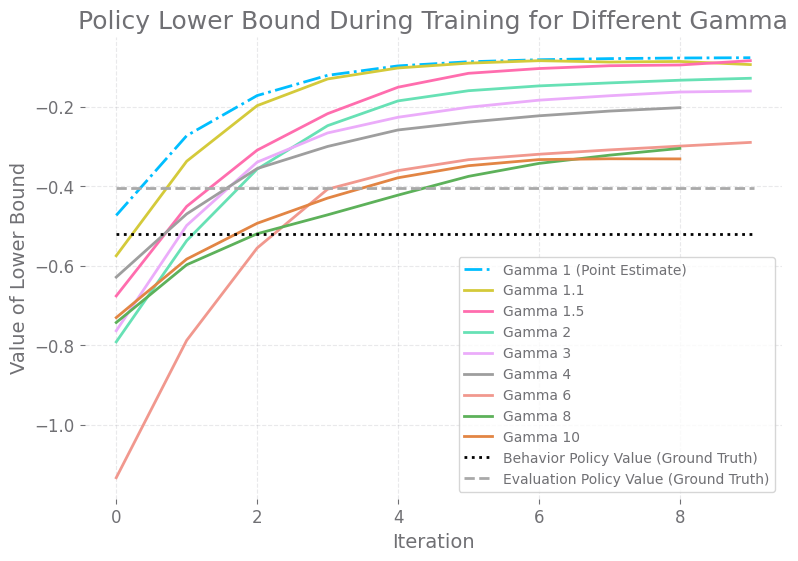

In [164]:
dataset_b_all = getSamplesMultiProc(int(10000), mdp, pi_b, horizon)
pi_b_value_all = confound_mdp.calc_returns(dataset_b_all, 1, horizon).mean()

dataset_e_all = getSamplesMultiProc(int(10000), mdp, np.array([pi_e, pi_e]), horizon)
pi_e_value_all = confound_mdp.calc_returns(dataset_e_all, 1, horizon).mean()

fig, ax = plt.subplots(figsize=(9, 6))
for idx, loss in enumerate(lossGams):
    if idx == 0:
        ax.plot(loss, label='Gamma '+str(gams[idx])+' (Point Estimate)', linestyle='dashdot')
    else:
        ax.plot(loss, label='Gamma '+str(gams[idx]))
        
plt.axhline(pi_b_value_all, xmin=0.045, xmax=0.96, 
            linestyle='dotted', c='black', label='Behavior Policy Value (Ground Truth)')
plt.axhline(pi_e_value_all, xmin=0.045, xmax=0.96, 
            linestyle='--', c='darkgrey', label='Evaluation Policy Value (Ground Truth)')

ax.legend()
ax.set_title("Policy Lower Bound During Training for Different Gamma")
ax.set_xlabel('Iteration')
ax.set_ylabel('Value of Lower Bound')

Text(0, 0.5, 'Value of Lower Bound')

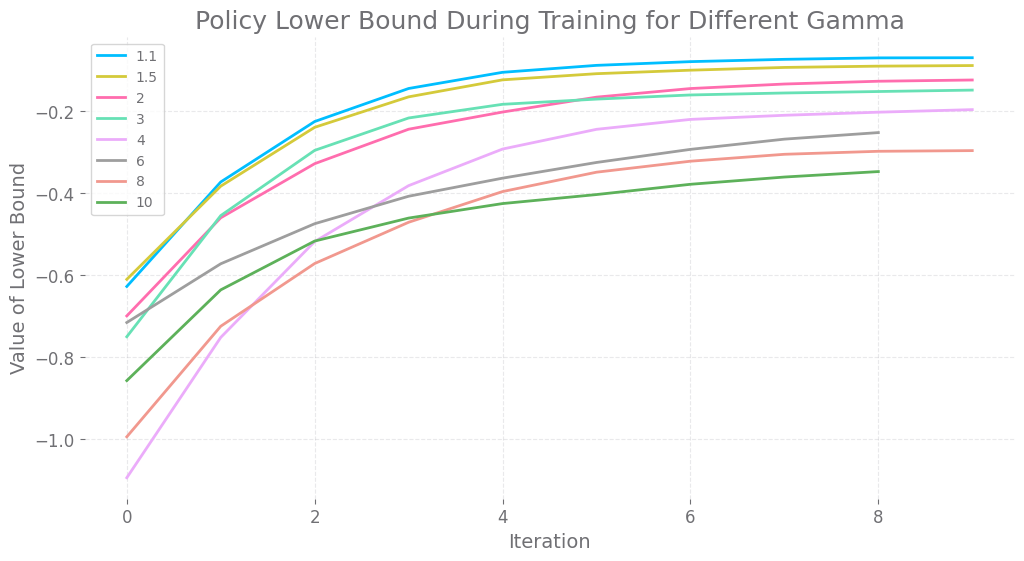

In [16]:
dataset_b_all = getSamplesMultiProc(int(10000), mdp, pi_b, horizon)
pi_b_value_all = confound_mdp.calc_returns(dataset_b_all, 1, horizon).mean()

dataset_e = getSamplesMultiProc(int(10000), mdp13, np.array([pi_e, pi_e]), horizon)
pi_e_value = confound_mdp.calc_returns(dataset_e[dataset_e[:,0,0] == 13], 1, horizon).mean()

fig, ax = plt.subplots(figsize=(12, 6))
for idx, loss in enumerate(lossGams):
    ax.plot(loss, label=gams[idx])
ax.legend()
ax.set_title("Policy Lower Bound During Training for Different Gamma")
ax.set_xlabel('Iteration')
ax.set_ylabel('Value of Lower Bound')

In [ ]:
torch.autograd.set_detect_anomaly(True)
losses, lossDyn, polImp, policy = improveTorchPolicy(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, mdp.x_dist, gam=10)
policy = torch.softmax(torch.tensor(policy), axis=1).detach().numpy()

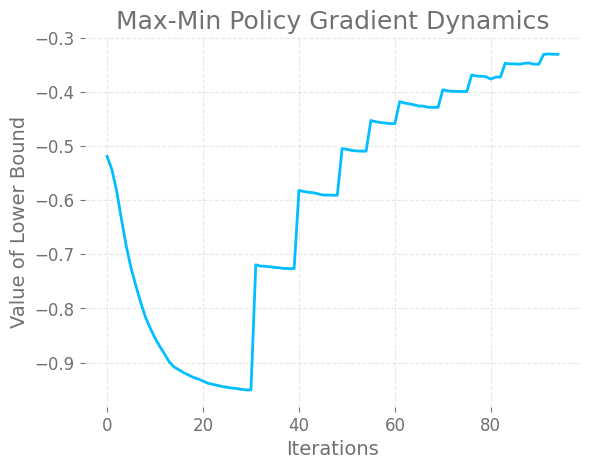

In [162]:
# This plot was generated with horizon 8
plt.plot(lossDyn)
plt.xlabel('Iterations')
plt.ylabel('Value of Lower Bound')
plt.title('Max-Min Policy Gradient Dynamics')
plt.savefig('figs/lossDyns.png')

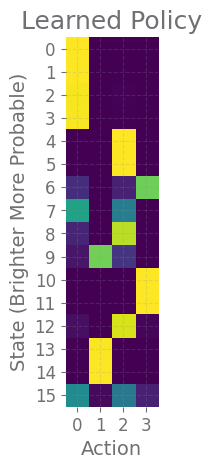

In [50]:
# This plot was generated with horizon 8
plt.imshow(policy)
plt.xticks(np.arange(nActions))
plt.yticks(np.arange(nStates))
plt.xlabel('Action')
plt.ylabel('State (Brighter More Probable)')
plt.title('Learned Policy')
plt.savefig('figs/policy.png')

In [23]:
def fitted_q_update(f, pi_e, dataset, R_sa, mdp):
    nStates = mdp.n_states
    nActions = mdp.n_actions
    data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
    regression_data = np.array([[x, a, (pi_e[int(xp)] @ f[int(xp),:])] for x,a,u,xp,r in data])
    for i in regression_data:
        i[2] += R_sa[int(i[0]), int(i[1])] 
    Tf_hat = np.zeros((nStates, nActions))
    for x,a,y in regression_data:
        Tf_hat[int(x), int(a)] += y
    idx, count = np.unique(data[:,:2], axis=0, return_counts=True)
    for i,[x,a] in enumerate(idx):
        Tf_hat[int(x),int(a)] /= count[i]
    return Tf_hat

polVals = []
for policy in policyGams:
    print("value of pi_e with no confounding")
    Q0 = np.zeros((nStates, nActions))
    nom_q = Q0.copy()
    for t in range(horizon):
        nom_q = fitted_q_update(nom_q, policy, dataset, Rhat_sa, mdp)
    polVals.append(mdp.get_value(nom_q, policy)[1])

value of pi_e with no confounding
value of pi_e with no confounding
value of pi_e with no confounding
value of pi_e with no confounding
value of pi_e with no confounding
value of pi_e with no confounding
value of pi_e with no confounding
value of pi_e with no confounding


In [24]:
polVals = []
for policy in policyGams:
    print("value of pi_e with no confounding")
    Q0 = np.zeros((nStates, nActions))
    cfqe = Q0.copy()
    for t in range(horizon):
        #cfqe = CFQE(cfqe, pi_e, pi_bsa, Pb_spsa, gam, R_sa)
        cfqe = CFQE(cfqe, policy, pi_bsa, Pb_spsa, 1, R_sa)
    print(mdp.get_value(cfqe,policy)[1])
    polVals.append(mdp.get_value(cfqe, policy)[1])

value of pi_e with no confounding
-0.12899810067943923
value of pi_e with no confounding
-0.12475608480118588
value of pi_e with no confounding
-0.13787532059813454
value of pi_e with no confounding
-0.1255120032386063
value of pi_e with no confounding
-0.12671391156013134
value of pi_e with no confounding
-0.1450726889433202
value of pi_e with no confounding
-0.13841190823814734
value of pi_e with no confounding
-0.1256781424410646


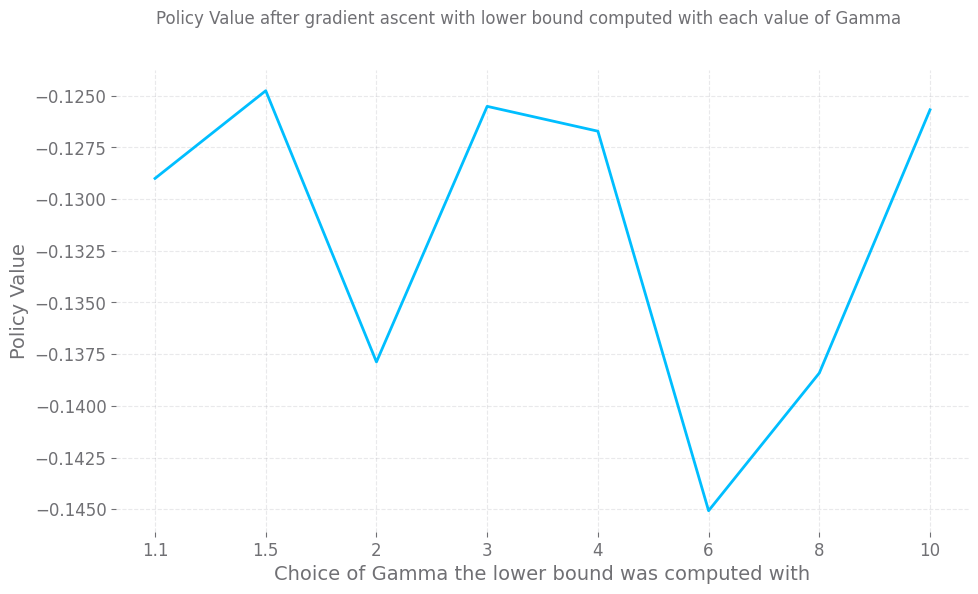

In [26]:
plt.figure(figsize=((11, 6)))
plt.plot(polVals)
plt.xticks([i for i in range(len(polVals))], [str(gam) for gam in gams])
plt.suptitle('Policy Value after gradient ascent with lower bound computed with each value of Gamma')
plt.xlabel("Choice of Gamma the lower bound was computed with")
plt.ylabel("Policy Value")
plt.savefig('figs/polValues.png')

# is this normal? it could be! can we prove this is a general result?
#large gammas could be distinguishable
#some finite amount of uncertainty is enough that you do something very conservative

In [ ]:
relaxEnvsTrials = []
objEnvsTrials = []
torchEnvsTrials = []
cfqeEnvsTrials = []
fqeEnvsTrials = []
for trial in range(30):
    print('TRIAL:', trial)
    relaxEnvs = []
    objEnvs = []
    torchEnvs = []
    cfqeEnvs = []
    fqeEnvs = []

    #gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
    gams = [1, 5, 10, 15, 25, 35, 50]
    nGams = len(gams)

    #hadds = [0, 5, 10]
    hadds = [0]

    envNo = 0
    for mdp, pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma in envs:

        print("---")

        for h in hadds:
            horizon = base_horizon + h

            print("running env with horizon " + str(horizon))

            dataset = getSamplesMultiProc(int(10000), mdp, pi_b, horizon, start_seed=trial*multiprocessing.cpu_count())
            data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
            Phat = confound_ope.estimate_P(dataset, mdp)
            pihat = confound_ope.estimate_pi(dataset, mdp)
            for a in range(nActions):
                for s in range(nStates):
                    if Phat[a,s].sum() == 0:
                        Phat[a,s,term] = 1
                    if pihat[s].sum() == 0:
                        pihat[s,:] = 1/nActions
            pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]

            # This is the actual reward_sa
            # P(s,a,s') * R(s,a,s')
            # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
            R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
            P_spsa = Phat.transpose((2, 1, 0))
            n = data.shape[0]

            Rhat_sa = (Phat * confound_ope.estimate_R(dataset, mdp)).sum(axis=2).T

             # behavior value
            print("value of pi_b")
            returns = confound_mdp.calc_returns(dataset, 1, horizon)
            print(returns.mean())

            pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)

            Pb_spsa = getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P)
            N_sa = np.zeros((nStates, nActions))
            for s,a,u,sp,r in data:
                N_sa[int(s),int(a)] += 1

            print('fqe and cfqe')
            fqe_results = []
            cfqe_results = []
            for gam in gams: 
                Q0 = np.zeros((nStates, nActions))
                cfqe = Q0.copy()
                for t in range(horizon):
                    #cfqe = CFQE(cfqe, pi_e, pi_bsa, Pb_spsa, gam, R_sa)
                    #fqe = CFQE(cfqe, pi_e, pi_bsa, Pb_spsa, 1, R_sa)
                    cfqe = CFQE(cfqe, pi_e, pi_bsa, P_spsa, gam, Rhat_sa)
                    fqe = CFQE(cfqe, pi_e, pi_bsa, P_spsa, 1, Rhat_sa)
                cfqe_results.append(mdp.get_value(cfqe,pi_e)[0])
                fqe_results.append(mdp.get_value(fqe,pi_e)[0])
            cfqeEnvs.append(cfqe_results)
            fqeEnvs.append(fqe_results)


            print('relax')
            relaxEnvs.append(mbrlRelax(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, gams))
            print('MB')
            objEnvs.append([mbrlLoop(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, gams, so, 
                                     lb=np.min([1.5*relaxEnvs[envNo][:,so], -5*np.ones(len(gams))], axis=0)) 
                            for so in tqdm([13])])
            #objEnvs.append([mbrlLoop(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, so) for so in range(nStates)])
            print('torch')
            torchEnvs.append([getTorchVals(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, gams, so) for so in tqdm([13])])
            #torchEnvs.append([getTorchVals(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, so) for so in range(nStates)])

            envNo += 1
    relaxEnvsTrials.append(relaxEnvs)
    objEnvsTrials.append(objEnvs)
    torchEnvsTrials.append(torchEnvs)
    cfqeEnvsTrials.append(cfqeEnvs)
    fqeEnvsTrials.append(fqeEnvs)

TRIAL: 0
---
running env with horizon 8
value of pi_b
-0.5198843149038463
fqe and cfqe
relax


  0%|          | 0/1 [55:55<?, ?it/s]


MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.29s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7013, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7013, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-0.9902, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0076, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7013, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0261, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7013, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0338, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7013, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0398, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0575, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7013, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0445, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0599, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7013, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0456, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0618, device='cuda:0', grad_fn=<Do

100%|██████████| 1/1 [00:16<00:00, 16.69s/it]

TRIAL: 2
---
running env with horizon 8


value of pi_b
-0.5253094951923077
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.16s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7051, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7051, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0119, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0303, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7051, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0486, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0661, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7051, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0583, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0757, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7051, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0651, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0811, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7051, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0663, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0858, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7051, device='cuda:0', grad_fn=<Do

100%|██████████| 1/1 [00:17<00:00, 17.95s/it]

TRIAL: 3
---
running env with horizon 8


value of pi_b
-0.5287314703525642
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.25s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7107, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7107, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0036, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0237, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7107, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0416, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7107, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0507, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0687, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7107, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0571, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0731, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7107, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0606, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7107, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0628, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:15<00:00, 15.82s/it]

TRIAL: 4
---
running env with horizon 8


value of pi_b
-0.5221514423076924
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.06s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0120, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0528, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0606, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0672, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0697, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0711, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:13<00:00, 13.14s/it]

TRIAL: 5
---
running env with horizon 8


value of pi_b
-0.525594951923077
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.10s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7330, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7330, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0223, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7330, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0636, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7330, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0712, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7330, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0773, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0925, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7330, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0793, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7330, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0812, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:15<00:00, 15.31s/it]

20 tensor(-1.0962, device='cuda:0', grad_fn=<DotBackward0>)
TRIAL: 6
---
running env with horizon 8


value of pi_b
-0.5264518229166668
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.26s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7162, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7162, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-0.9902, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7162, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0248, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7162, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0297, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0524, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7162, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0355, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7162, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0384, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7162, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0383, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:14<00:00, 14.64s/it]

TRIAL: 7
---
running env with horizon 8


value of pi_b
-0.5141005608974359
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.06s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.6882, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6882, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-0.9860, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0070, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6882, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0248, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0435, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6882, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0313, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0532, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6882, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0381, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6882, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0408, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0624, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6882, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0432, device='cuda:0', grad_fn=<Do

100%|██████████| 1/1 [00:18<00:00, 18.32s/it]

TRIAL: 8
---
running env with horizon 8


value of pi_b
-0.5159324919871795
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.18s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7200, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7200, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-0.9815, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7200, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0131, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0334, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7200, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0196, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0406, device='cuda:0', grad_fn=<DotBackward0>)
30 tensor(-1.0481, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7200, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0244, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7200, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0244, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7200, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0286, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.64s/it]

TRIAL: 9
---
running env with horizon 8


value of pi_b
-0.5279987980769232
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.00s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-0.9880, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0029, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0228, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0308, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0356, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0392, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7117, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0399, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:13<00:00, 13.47s/it]

TRIAL: 10
---
running env with horizon 8


value of pi_b
-0.5224714543269231
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.22s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.6993, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6993, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0006, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0204, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6993, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0419, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6993, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0512, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0709, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6993, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0580, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0755, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6993, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0611, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0784, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6993, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0634, device='cuda:0', grad_fn=<Do

100%|██████████| 1/1 [00:17<00:00, 17.77s/it]

TRIAL: 12
---
running env with horizon 8


value of pi_b
-0.5356375200320515
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.11s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7216, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7216, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0027, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0197, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7216, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0371, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0548, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7216, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0453, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0625, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7216, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0494, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0658, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7216, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0517, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0696, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7216, device='cuda:0', grad_fn=<Do

100%|██████████| 1/1 [00:17<00:00, 17.06s/it]

20 tensor(-1.0692, device='cuda:0', grad_fn=<DotBackward0>)
TRIAL: 13
---
running env with horizon 8


value of pi_b
-0.5263731971153848
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.17s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7142, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7142, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0150, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7142, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0553, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7142, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0608, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7142, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0685, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7142, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0713, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7142, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0732, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:13<00:00, 13.36s/it]

TRIAL: 14
---
running env with horizon 8


value of pi_b
-0.527742888621795
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.13s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7048, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7048, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-0.9888, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7048, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0226, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7048, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0306, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7048, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0352, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7048, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0376, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0538, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7048, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0394, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:12<00:00, 12.77s/it]

TRIAL: 15
---
running env with horizon 8


value of pi_b
-0.5224053485576924
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.27s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7236, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7236, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0018, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7236, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0351, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0516, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7236, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0416, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7236, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0450, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7236, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0489, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7236, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0491, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0685, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:15<00:00, 15.12s/it]

TRIAL: 16
---
running env with horizon 8


value of pi_b
-0.517879106570513
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.25s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7078, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7078, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0138, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7078, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0552, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7078, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0623, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7078, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0702, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0847, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7078, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0739, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7078, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0762, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:14<00:00, 14.07s/it]

TRIAL: 17
---
running env with horizon 8


value of pi_b
-0.5209820713141026
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:03<00:00, 63.98s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.6972, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6972, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-0.9960, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0155, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6972, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0358, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6972, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0439, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0613, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6972, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0506, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0671, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6972, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0535, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6972, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0557, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.02s/it]

TRIAL: 18
---
running env with horizon 8


value of pi_b
-0.5227669270833334
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.12s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.6896, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6896, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-0.9915, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0114, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6896, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0272, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6896, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0354, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6896, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0435, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0628, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6896, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0465, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6896, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0468, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0670, device='cuda:0', grad_fn=<DotBackward0>)
30 tensor(-1.0763, device='cuda:0', grad_fn=<Do

100%|██████████| 1/1 [00:18<00:00, 18.21s/it]

TRIAL: 19
---
running env with horizon 8


value of pi_b
-0.5245923477564103
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:05<00:00, 65.38s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.6978, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6978, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-0.9978, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6978, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0368, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6978, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0437, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6978, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0514, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0723, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6978, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0551, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6978, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0562, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0738, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:18<00:00, 18.48s/it]

TRIAL: 20
---
running env with horizon 8


value of pi_b
-0.5190635016025641
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.50s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7127, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7127, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-0.9781, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-0.9956, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7127, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0082, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0264, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7127, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0148, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7127, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0197, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7127, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0234, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7127, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0239, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:18<00:00, 18.73s/it]

TRIAL: 21
---
running env with horizon 8


value of pi_b
-0.5191861979166666
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.46s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.6926, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6926, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-0.9847, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6926, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0234, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0420, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6926, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0307, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0494, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6926, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0374, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0543, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6926, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0403, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6926, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0423, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:20<00:00, 20.10s/it]

TRIAL: 22
---
running env with horizon 8


value of pi_b
-0.5030193309294873
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.86s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.6783, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6783, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-0.9890, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0062, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6783, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0304, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6783, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0410, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6783, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0483, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0636, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6783, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0513, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0679, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.6783, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0536, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:18<00:00, 18.83s/it]

TRIAL: 23
---
running env with horizon 8


value of pi_b
-0.5253185096153847
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:04<00:00, 64.45s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7136, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7136, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0011, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7136, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0351, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7136, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0425, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0603, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7136, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0504, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0669, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7136, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0513, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0680, device='cuda:0', grad_fn=<DotBackward0>)
30 tensor(-1.0775, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7136, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0528, device='cuda:0', grad_fn=<Do

100%|██████████| 1/1 [00:21<00:00, 21.37s/it]

TRIAL: 24
---
running env with horizon 8


value of pi_b
-0.5263591746794872
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


100%|██████████| 1/1 [01:05<00:00, 65.36s/it]


torch


  0%|          | 0/1 [00:00<?, ?it/s]

0 tensor(-0.7185, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7185, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0022, device='cuda:0', grad_fn=<DotBackward0>)
20 tensor(-1.0216, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7185, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0381, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7185, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0431, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7185, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0499, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7185, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0512, device='cuda:0', grad_fn=<DotBackward0>)
0 tensor(-0.7185, device='cuda:0', grad_fn=<DotBackward0>)
10 tensor(-1.0544, device='cuda:0', grad_fn=<DotBackward0>)


100%|██████████| 1/1 [00:17<00:00, 17.22s/it]

TRIAL: 25
---
running env with horizon 8


value of pi_b
-0.517714342948718
fqe and cfqe
relax
MB


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


In [166]:
gams = [1, 5, 10, 15, 25, 35, 50]
nGams = len(gams)

In [ ]:
np.quantile(np.array(objEnvsTrials).squeeze(), 0.95, axis=0)

In [87]:
np.array(objEnvsTrials).squeeze().mean(0)

array([-0.72326421, -1.03108386, -1.07041537, -1.0803802 , -1.08813619,
       -1.09077133, -1.09248634])

In [84]:
np.array(relaxEnvsTrials).squeeze()[:,:,so].shape

(30, 7)

In [85]:
np.array(torchEnvsTrials).squeeze().shape

(30, 7)

In [86]:
np.array(cfqeEnvsTrials).squeeze()[:,:,so].shape

(30, 7)

In [123]:
mdp13 = copy.deepcopy(mdp)
mdp13.x_dist = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0])
dataset_b = getSamplesMultiProc(int(10000), mdp13, pi_b, horizon)
pi_b_value = confound_mdp.calc_returns(dataset_b[dataset_b[:,0,0] == 13], 1, horizon).mean()

dataset_e = getSamplesMultiProc(int(10000), mdp13, np.array([pi_e, pi_e]), horizon)
pi_e_value = confound_mdp.calc_returns(dataset_e[dataset_e[:,0,0] == 13], 1, horizon).mean()

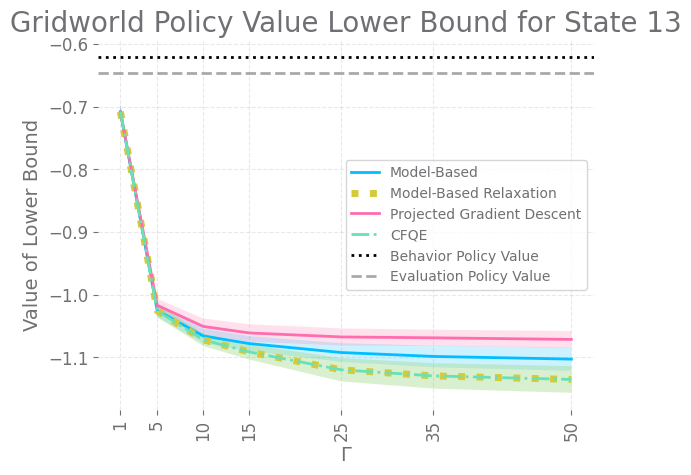

In [167]:
#envNames = ['ToyH', 'Toy', 'Graph', 'MC', 'Gridworld', 'GridworldLarge', 'RandWalk']
envNames = ['Gridworld']
for idx, env in enumerate(envs):
    mdp, pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma = env

    pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)

    for so in [13]:#range(nStates):
        #pi_b_val = mdp.get_value(nom_q,pi_bsa)[0][so]
        #pi_e_val = mdp.get_value(nom_q,pi_e)[0][so]

        fig, ax = plt.subplots()
        #change this to R_sa form
        #ax.axhline(pi_e_val, color='green', linestyle='--', label='pi_e_no_cf_state_' + str(so))
        #ax.axhline(pi_b_val, color='red', linestyle='--', label='pi_b')
        ax.set_xticks(gams, rotation='vertical')
        ax.set_xticklabels(gams, rotation=90)
        ax.set_xlabel('$\Gamma$')
        ax.set_ylabel('Value of Lower Bound')
        plt.title(envNames[idx] + " " + "Policy Value Lower Bound for State " + str(so), size=20)

        mbmean = np.array(objEnvsTrials).squeeze().mean(0)
        mbstd = np.array(objEnvsTrials).squeeze().std(0)
        ax.plot(gams, mbmean, label='Model-Based', alpha=1)
        ax.fill_between(gams, mbmean-mbstd,
                       mbmean+mbstd,
                       alpha=0.2)
        relaxmean = np.array(relaxEnvsTrials).squeeze()[:,:,so].mean(0)
        relaxstd = np.array(relaxEnvsTrials).squeeze()[:,:,so].std(0)
        ax.plot(gams, relaxmean, 
                label='Model-Based Relaxation', linewidth=5.0, linestyle='dotted')
        ax.fill_between(gams, relaxmean-relaxstd,
                       relaxmean+relaxstd,
                       alpha=0.2)
        #ax.plot(gams, np.array(fqe_results)[:,so], label='David FQE_state_'+str(so))
        projmean = np.array(torchEnvsTrials).squeeze().mean(0)
        projstd = np.array(torchEnvsTrials).squeeze().std(0)
        ax.plot(gams, projmean, label='Projected Gradient Descent', alpha=1)
        ax.fill_between(gams, projmean-projstd,
                       projmean+projstd,
                       alpha=0.2)
        cfqemean = np.array(cfqeEnvsTrials).squeeze()[:,:,so].mean(0)
        cfqestd = np.array(cfqeEnvsTrials).squeeze()[:,:,so].std(0)
        ax.plot(gams, cfqemean, label='CFQE', linestyle='dashdot')
        ax.fill_between(gams, cfqemean-cfqestd,
                       cfqemean+cfqestd,
                       alpha=0.2)
        
        plt.axhline(pi_b_value, linestyle='dotted', c='black', label='Behavior Policy Value')
        plt.axhline(pi_e_value, linestyle='--', c='darkgrey', label='Evaluation Policy Value')

        ax.legend()
        #plt.savefig("plots/sampling"+envNames[idx]+"State"+str(so)+".jpg")
        plt.savefig("figs/sampling"+envNames[idx]+"State"+str(so)+".jpg")

In [95]:
np.quantile(np.array(objEnvsTrials).squeeze(), 0.95, axis=0)

array([-0.72326421, -1.03108386, -1.07041537, -1.0803802 , -1.08813619,
       -1.09077133, -1.09248634])

In [100]:
np.array(torchEnvsTrials).squeeze().std(0)

array([0., 0., 0., 0., 0., 0., 0.])

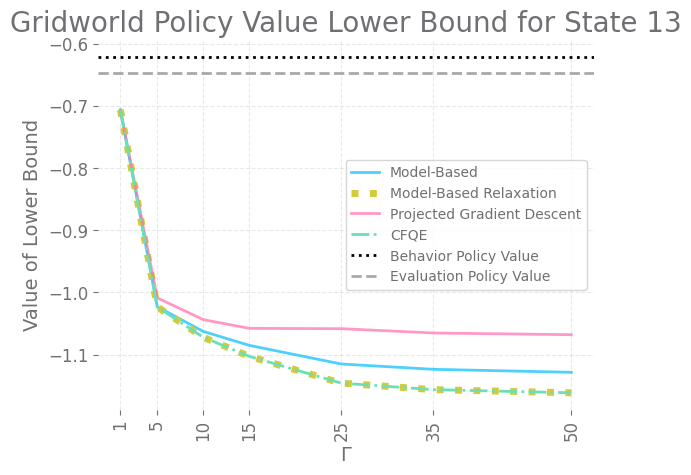

In [169]:
#envNames = ['ToyH', 'Toy', 'Graph', 'MC', 'Gridworld', 'GridworldLarge', 'RandWalk']
envNames = ['Gridworld']
for idx, env in enumerate(envs):
    mdp, pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma = env

    pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)

    for so in [13]:#range(nStates):
        #pi_b_val = mdp.get_value(nom_q,pi_bsa)[0][so]
        #pi_e_val = mdp.get_value(nom_q,pi_e)[0][so]

        fig, ax = plt.subplots()
        #change this to R_sa form
        #ax.axhline(pi_e_val, color='green', linestyle='--', label='pi_e_no_cf_state_' + str(so))
        #ax.axhline(pi_b_val, color='red', linestyle='--', label='pi_b')
        ax.set_xticks(gams, rotation='vertical')
        ax.set_xticklabels(gams, rotation=90)
        ax.set_xlabel('$\Gamma$')
        ax.set_ylabel('Value of Lower Bound')
        plt.title(envNames[idx] + " " + "Policy Value Lower Bound for State " + str(so), size=20)

        ax.plot(gams, objEnvs[idx][0], label='Model-Based', alpha=0.7)
        ax.plot(gams, relaxEnvs[idx].T[so], label='Model-Based Relaxation', linewidth=5.0, linestyle='dotted')
        #ax.plot(gams, np.array(fqe_results)[:,so], label='David FQE_state_'+str(so))
        ax.plot(gams, torchEnvs[idx][0], label='Projected Gradient Descent', alpha=0.7)
        ax.plot(gams, np.array(cfqeEnvs[idx]).T[so], label='CFQE', linestyle='dashdot')
        
        
        plt.axhline(pi_b_value, linestyle='dotted', c='black', label='Behavior Policy Value')
        plt.axhline(pi_e_value, linestyle='--', c='darkgrey', label='Evaluation Policy Value')
        

        ax.legend()
        #plt.savefig("plots/sampling"+envNames[idx]+"State"+str(so)+".jpg")

In [68]:
pi_b_value

-0.6205248397435899

In [71]:
pi_e_value

-0.6460857371794873